## Install Libraries

In [ ]:
%%capture
# !apt install git-lfs
!pip install accelerate==0.19.0
!pip install transformers==4.28.0

In [ ]:
# import wandb
# wandb.login(key='cc749ecdd83fa0ad0850227d24b90e0dded7e724')

## Import Libraries

In [1]:
import numpy as np
import math
import gc
import transformers
print(transformers.__version__)
from transformers.utils import send_example_telemetry
send_example_telemetry("language_modeling_notebook", framework="pytorch")
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
import pandas as pd
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML
from transformers import AutoModelForMaskedLM
# from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from transformers import AutoTokenizer

4.28.0


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Load Dataset

In [2]:
datasets = load_dataset(
    'csv',
    data_files={
        'train': '/kaggle/input/amazon-products-mlm-dataset/test.csv',
        'test': '/kaggle/input/amazon-products-mlm-dataset/test.csv'
    }
)

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
datasets = datasets.remove_columns('Unnamed: 0')

In [4]:
# train_dataset = train_dataset.select(list(range(1000000)))
# test_dataset = test_dataset.select(list(range(10000)))

In [5]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [6]:
show_random_elements(datasets['train'], 8)

,text
0,"Sea-Doo New OEM 1 Liter Waterproof Dry Pouch Bag , 4695400090"
1,These fun sporty tees are apt for everyday wear and are avaliable at knockout prices
2,Water Resistance Level : Water Resistant
3,This T shirts is usual fit size made from 100 % cotton which makes you feel more easy and comfortable .
4,vacation
5,hang or line dry
6,You ' ll stay warm and mobile in this Apprentice full zip hoodie designed to resist weather and wind
7,Packed in Carton Box


## Inference Masked Language Model

In [7]:
model_checkpoint = "RishiDarkDevil/distilroberta-base-finetuned-amazon-products"

In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", use_fast=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [9]:
model

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [10]:
from transformers import pipeline

In [19]:
datasets['train'][4]

{'text': "EASY and QUICK 2 MINUTE SET-UP and even faster pack-away ! Kickster Elite soccer goals are made with QUICKPLAY ' s unique pre-attached pole system for fast and easy set-up and pack away , so easy there is no need for an instruction manual"}

In [153]:
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

In [190]:
fill_mask('TV with <mask>')

[{'score': 0.3210941553115845,
  'token': 33565,
  'token_str': ' Remote',
  'sequence': 'TV with Remote'},
 {'score': 0.12474970519542694,
  'token': 6063,
  'token_str': ' remote',
  'sequence': 'TV with remote'},
 {'score': 0.053780511021614075,
  'token': 1413,
  'token_str': ' stand',
  'sequence': 'TV with stand'},
 {'score': 0.043620042502880096,
  'token': 13371,
  'token_str': ' Stand',
  'sequence': 'TV with Stand'},
 {'score': 0.024881886318325996,
  'token': 30393,
  'token_str': ' HDMI',
  'sequence': 'TV with HDMI'}]

In [27]:
import torch

In [202]:
model = AutoModelForMaskedLM.from_pretrained('distilroberta-base', output_hidden_states = True, output_attentions=True)
# model = AutoModelForMaskedLM.from_pretrained(model_checkpoint, output_hidden_states = True, output_attentions=True)

In [203]:
def bert_text_preparation(text, tokenizer):
    """Preparing the input for RoBERTA    
    """
    marked_text = "<s> " + text + " </s>"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])

    return tokenized_text, tokens_tensor

In [204]:
tokenizer

RobertaTokenizerFast(name_or_path='distilroberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [205]:
bert_text_preparation('High quality 100% cotton fabric.', tokenizer)

(['<s>',
  'ĠHigh',
  'Ġquality',
  'Ġ100',
  '%',
  'Ġcotton',
  'Ġfabric',
  '.',
  'Ġ',
  '</s>'],
 tensor([[    0,   755,  1318,   727,   207, 13178, 10199,     4,  1437,     2]]))

In [206]:
def get_bert_embeddings(tokens_tensor, model):
    """Get embeddings from an embedding model
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor)
        hidden_states = outputs.hidden_states

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)

    return token_embeddings

In [223]:
phrase_embedding_list = list()

In [224]:
phrases = ['college dorm decor',
 'a virtual casino',
 'empty glass bottle',
 'dji mavic air',
 'multiple shockproof materials ]',
 'traditional 5-pocket styling',
 '. skid-resistant backing',
 'bahubali silk saree',
 '" the carpet city',
 'data transfer speed',
 'the shimmering qualities',
 '. premium fabric',
 'plese',
 'product materials',
 'shrink polyester',
 'boho beaded necklace',
 'the colours',
 'classical design',
 'high quality canvas',
 'audio return channel',
 'the black and white greek key pattern',
 '1.6 cm',
 'fabric treatment',
 'us 20 to 22',
 'performance grade primary and secondary bobbins',
 '8 pieces',
 '2 years quality assurance',
 'wooden printed coasters',
 '4.56',
 'the nicetown store',
 'omega 3',
 'easy or quick release buckling',
 'those or even home decor',
 '1 piece extra long door curtain',
 '100 % premium textured polyester fabric',
 'seamless style',
 'an envelope',
 'back cut-to-fit grid lines design',
 'show',
 'a great top',
 'diy projects',
 'mint matte',
 '2 money pockets',
 'pillar',
 'women western aztec sweaters',
 'happy diwali',
 'easier application',
 'strong screws',
 '1 package',
 '685 grams',
 'home bars',
 'overall size',
 'special techniques',
 'pole length',
 'rich velvet curtains',
 'a 5x7 portrait',
 '3.1amp fast charging',
 "this women ' s shoe",
 'usagelight weight',
 'kolkata',
 'our get organized system',
 'hologrpahic wristband',
 'triple layer',
 'football sleeves',
 'the health breeze mode',
 '2 pillow covers 46cm x 68cm',
 'weathered patina',
 'quality prefect',
 'festival occasion',
 'screw back closure',
 'bad side table',
 '1000 dpi scroll wheel',
 'your personalized costumes',
 'white colored cars',
 'natural style',
 'best thread',
 'multipurpose storage wooden almirah cabinet wardrobe drawers and doors',
 'collapsiblesaves space',
 'closurezipper',
 'those picture-perfect moments',
 'paradise flowers',
 'no more holes',
 'better temperature regulation',
 'food residue and debris',
 'consistent control , comfort and stability',
 'storage container',
 'full visibility',
 'fresh salad cups 100 % brand new',
 'simple plug and play design',
 'hand painted painting',
 'front storage zip-up compartments',
 'france',
 'gunmetal',
 'all devices',
 'vetrians day',
 'oakley',
 'excellent quality',
 'a multi-level terrace design',
 'perfect valentine gifts',
 'decorate cell phone case',
 'measurement guide',
 'ride-up',
 'pressure',
 'no stimulation',
 'gently contoured yet athletic fit',
 '. hassle-free hanging',
 '4xl48',
 'a seamless customer experience',
 'scratches and damage',
 'motel',
 'all-in-one complete brake kit replacement',
 'spot treatment',
 'free length',
 'wine',
 'the old city',
 "warping , won ' t crack or rust",
 'roofing',
 'water resistance bike body cover',
 '8.6x1.1x12.6 inch',
 'a great experience',
 '3-inch rod pocket',
 'premium quality , flip cover',
 'one ink bottle',
 'dormitory',
 'gorgeous nature painting',
 'gaming keyboard',
 'a passport wallet',
 'precautions',
 'choices',
 'high quality denim fabric one-of-a-kind fabric feel premium',
 'axter',
 'fabric80 % cotton',
 'crocodile creek',
 '15.95 inch',
 'right leg',
 'safe and durable ]',
 'the surface coating',
 '32x48 inches',
 '3d high definition printing',
 'grille',
 'hp omen 17',
 "the child ' s memory",
 'ford 3d stickers',
 'the wood surface',
 'no stand',
 'bright metallic and reflective painting',
 '2.44-inch',
 'peel',
 'a total height',
 'diy',
 'frisky feet',
 'casual , yoga',
 'shampoo',
 'evenly',
 'monetary benefits',
 'tempered glass',
 'x 26',
 'sustainable hydrofree dwr treatment',
 'styleeasy',
 'our unique breeze-pass technology',
 'your senses',
 'cool wearing experience',
 'a-line kurti',
 'ruf and tuff',
 '2000',
 '4 * knives',
 'dressing',
 'optimum',
 'ultimate comfort and softness',
 'the language',
 'wide leg pants',
 'minimal seams',
 '2 meters',
 'sherpa fleece lined collar',
 'home fragrance',
 'two year unlimited mile warranty',
 'double pack',
 'women casual summer 3 or 4 sleeve blouses',
 'super fine monofilament top',
 'loafer',
 'this postwr',
 'a beautiful , unique design',
 '. feature-shopping , gifting',
 'sports training',
 'the closet or garage',
 'high quality acrylic',
 '. easy maintenance',
 'the adjustable velcro closure switch',
 'high quality durable linen',
 'l ”',
 'your own desserts',
 '2 front pockets',
 'your living room mantel',
 'ngos',
 '1 saree',
 'this chain tensioner',
 '2 matching tiebacks',
 'practical size',
 'the recepients',
 'terrace farming',
 'the chain strap length',
 'harsh cleaning agents',
 'file bag',
 'special features 2',
 'matte finish state-of-the-art printing process',
 'sheer curtain',
 'flexible mop head',
 'contrasting , self-material shoulder inserts',
 'width',
 'satin black frame',
 'a very noticeable way',
 'ages 3 and up',
 'selected pvc material',
 '6000 approx',
 'insulated drapes',
 'original factory component',
 'about 15.5lbs',
 'body ache',
 'graduation gift',
 'pikachu soft toys',
 '8 silver grommets',
 'prismalock technology',
 'superior product and design quality',
 'fancy designer look',
 'finish feel',
 'free style',
 'kurta straight',
 'warming and christmas',
 'the cold day',
 'similar fabric and colors',
 'the abuse',
 '4 same-colored weighted bags',
 'office bag',
 'oneplus 9r protective case',
 'password combination',
 'darling',
 'green lantern products',
 '20 to 24 inch',
 'case size',
 'lantern sleeve design',
 '. usb port',
 "the bike ' s crash guard",
 'kurta length',
 'two distinct sizes',
 'dotted',
 'electric equipment',
 'any warranty',
 'styling purpose',
 'the cart frame',
 'book store',
 'high-quality led lamps',
 'complete automationactivate 10 , 20 , 40 minute pre-set schedules',
 'a pro this cake decorating set',
 'same material',
 '. proven and guaranteed',
 'stains and mildew',
 '2 meter',
 'indoor or outdoor use',
 'scissors',
 'high quality poly-carbonate material',
 'no more fingerprint smudges',
 'even pet hair',
 'california proposition 65',
 'the basket and openwork design',
 'the diy drawer divider',
 'stylish design',
 'the operations',
 'the penetration',
 'sliding surfaces',
 '9 cm height',
 'those long walks',
 'soft polyester water-friendly woven lining',
 'sauf',
 'this stylish windmill',
 'leather-nylon straps',
 'rich and funky colors',
 'rust',
 'your inner peace',
 'pacific gold',
 'oppo a54',
 'comparable standard treble',
 'a mild soapy solution',
 'plastic back cover compatible screen guard',
 'low-end rubber',
 'great leg protective cover',
 'military tactical pouch bagpack',
 'install and unfold',
 'images',
 'your iphone',
 'a protective tube',
 'backstrap',
 'silicone adhesive coating',
 'support material',
 'other standard mugs',
 'loose pin',
 'gt-air ii design concept',
 'a durable handle',
 'zx',
 'our womens football charcoal-edition t-shirt',
 'religious festivals',
 'one another',
 'satisfyingly crunchy crust',
 'a sensational mix',
 'back zip',
 'wolkomhome premium',
 'high quality print',
 'women dressy tops',
 'user health risks',
 'swing dress',
 'framed artwork',
 'reinforced edges',
 'a heavy 3 pass foamback liner',
 'high security',
 'the convene collection',
 'walls and floors',
 'multi mode',
 'tüv rheinland',
 'up to ten players',
 'the light colour t-shirt',
 '1 piece pregnancy body pillow or pillowcase',
 'using ways',
 'sparetail',
 'door',
 'sweat and oil residue',
 'the dining room',
 'health fit slippers',
 'manicure tools',
 'solid color fabric',
 'denim jeans',
 'waist 26 inch',
 'sheer floral net curtain',
 'blue color case cover',
 '2 or 0.2 or 2.2 or 2.4 or 2.6 or 2.8',
 'this process',
 'high elastic waist',
 '5.25mtr',
 'wall shelf bathroom',
 'drops and bumps',
 '8 way stretch',
 '000 products',
 'g or kg or lb',
 'larger or small books',
 'xs 5.8 inch',
 'a wall painting',
 'shoulder lace blouse short tees plaid colorblock pullovers shirt',
 'a desktop lamp',
 'premium soft fabric',
 'this solid washing machine cleaner',
 'this sleek belt',
 'toss',
 'recognized artisans',
 'neckround neck',
 'a durable pocket',
 'dance performance',
 'omni-tech waterproof breathable seam-sealed membrane bootie construction',
 'wide72',
 'hxwxd',
 'the travel bottle key-chain holders',
 'your fine dining',
 '11d round corner edge',
 'one rubber seal',
 'ages 12',
 'ornamentals',
 'skin',
 'a thoughtful and memorable gift',
 'outside cold',
 'phase 3 air pro seat',
 'all aca regulations',
 'women swimsuit tops',
 'dedicated , padded laptop compartment',
 'your own markers',
 'this extra soft and terry textured t-shirt',
 'cards parties',
 'polyester fiber fabric',
 'washable curtain accessories',
 'hypo-allergenic steel posts',
 'a convenient name tag slot',
 'various styles',
 'footwear',
 'tie side bikini thong',
 'the truck rocker panels',
 'our shade',
 'the first glance',
 'high quality traditional america style handcrafted fully lined picnic basket',
 'a shoe weight',
 'black and red shimmered crop button shrug',
 '1.06 x 5.2mts',
 'zando swimsuits',
 'the eternal love',
 'flipflops and slippers',
 'stay-put tabs',
 'these stretchy pants',
 '. space saving and easy use',
 'stylish contemporary look',
 'bodycon slim fit',
 'your bike',
 '75 %',
 'soft brim',
 'its wallpaper roll',
 'chain running',
 'tm and 2019',
 '61 % polyester',
 'heat insulation',
 'whatup or contact',
 'the incognito collection',
 'our lights',
 'your special brother',
 'stress free care',
 'wall mirror',
 'fast feet',
 '78 x',
 'antique decor',
 'pencil holder',
 'other sizes and colour',
 'many projects',
 'elegant table decoration',
 "6 ' 0 inch",
 'gallery99 magic quotes textured paper',
 'drawer etc',
 'no ink smell',
 'even the minor scratches',
 '861 fitment',
 'our desire',
 '60hz wattage',
 'closing wounds',
 'ideal gifting product',
 'breathable textile lining',
 'your oily skin',
 '18 : 00 — 2 : 00',
 'portsmini hdmi',
 'the highest professional quality traditional oil color',
 'various and exquisite patterns',
 'height8 cm',
 'premium plastic',
 '1.8 liter',
 'crayon ink',
 'color and design',
 'soft microsuede',
 'a super soft place',
 '1 * travel pillow',
 'pet carrier bag',
 'home theater',
 'easy use',
 'the official warp or dash power adapter and dash type-c cable warp charge',
 'bright colors',
 'shock cords and locks',
 'leg side',
 'first',
 'odor protection technology',
 'creative farmer gardening plant pom fern',
 '54 inches',
 'transporting easy',
 'this seven chakra wand',
 '18 bangles',
 'the artistmaria starzyk',
 "' s choices",
 'a separate device',
 'solid colour soft and comfort plush fabric',
 'suede cloth',
 'your dollhouse',
 '100 % touch accuracy',
 'high-quality rabbit fur',
 'fleece',
 'powerful motor set',
 'high-quality fragrance',
 'weather adaptable',
 'air intake',
 'your new artwork',
 'the perfect feeding kurti',
 'microwave ovens',
 'high-quality satin',
 'premium quality patchesmade',
 '2 piece window curtains',
 'a super quality thick catpe',
 'upper arms',
 'this colorful melamine dinnerware',
 '# 90 or 14',
 'women v neck cotton long sleeve shirts',
 'darker the shade block more sunlight',
 'memorable gift item',
 'decoholic room darkening curtains',
 'retro loose lapel tartan shacket shirts',
 'any speed',
 'the product dimensions',
 'the shoulder straps',
 'bumps and shocks',
 'saturday kinght ltd',
 'vr',
 'any other party',
 'the grinding cup',
 'other thirst quenching drinks',
 'these feeding kurtas',
 'stylish and trendy rings',
 'incoming natural light',
 'super fun',
 'gripmore',
 'your smartphones',
 'loose dirt',
 'a great gift cute shirt',
 'the contour legacy leg pillow',
 'a triple locking system',
 '102 inches long x 66 inches wide1 piece flat bed top',
 'authentic wood grain',
 'unframed posters',
 'indian artistry',
 'soft and smooth',
 'our melamine dinner',
 'extremely thin carbon fiber vinyl film',
 ']',
 'adjustable and removeable clamps',
 'the handwriting',
 '. oleo phobic coating',
 'reinforced heel cap',
 'unconditional free returns',
 'open and closed door',
 'birthdays , parties',
 'different casual shoes',
 'cool dri t-shirts',
 'seamless playback',
 'a dishwasher',
 'the rise grain',
 'cnas',
 "the ' customer questions and answers",
 'radio frequency interference',
 'dining look',
 'big files',
 'chic design',
 'light filtering',
 'our fashion jewelry department',
 'a crisp garden fresh design',
 'product service quality and durability',
 'finished sculptures',
 'one year pan-india warranty',
 'your shoulder burden',
 'peel and stick',
 '3000 rpm stall converter',
 'cuff design',
 'oem part # tvrs016s',
 'these beautiful collections',
 'the gabriel ultra',
 'the body weight',
 'a sponge interior',
 'the decoration style',
 '2pcswindow curtain',
 'bedside units',
 'lovely dragon',
 'set includes',
 '1 shirt',
 'velvet',
 'height " 6 \' 1 inch inches',
 'your measurement details',
 'moisture wicking fleece lining',
 'toy phone case',
 'who',
 'both fun',
 'won',
 'frequent charging trouble',
 'croslite',
 'the flexibility',
 'foldable hands free neck fan',
 '2inch ultra high thickness foam panel',
 'medium-density fiber board ) wood vinyl print',
 'the front left leg',
 'runway shows',
 'shim materials',
 'm-wave header card',
 'dorman license lamp lens 68164',
 'all standard american sizes',
 'designer table clock roman numbers',
 '24 projector patterns',
 'double-needle hem',
 'the latch plate',
 'some situations',
 'this poly tarp',
 'this compact wardrobe closet',
 'your laptop computer',
 'heavy-duty cleaning applications',
 '325 lbs',
 'different pieces and designs',
 'our wrench shape wall hook',
 'green material',
 'cat houses',
 'the device',
 'kitchen gardening',
 'page',
 'ball diameter',
 'men and women',
 'unfavorable household smell',
 'sensortechnology',
 'this beautiful outfit',
 'wall décor',
 'jvc hafr325w white premium sound',
 'lightweight and waterproof material',
 'high quality porcelain ceramic',
 'specially developed metals and rubbers',
 'days',
 'the oil',
 'uvb',
 'extra strength',
 'godesses',
 'front floral patch',
 'newly painted walls',
 'fsc-certified gloss poster paper',
 'a great hostess , wedding or housewarming gift',
 'premium green display scale',
 'kitty party thanksgiving',
 '125ml',
 'leisure , party',
 'up and lower back , neck , arm , shoulder , waist , leg , foot etc',
 'this magic water repellent film',
 'high quality canvas print',
 'the original date',
 'record',
 '4 to 8 )',
 '1 or 2in',
 'boxwhich',
 '3xl48',
 'museum-grade enhanced white cotton blend',
 'sharpness',
 'flat',
 'construction lighting',
 'real clay cones',
 'the exact name',
 'preschool',
 'over 13 years',
 '036',
 'both handles',
 'good communication and service',
 'multi-use',
 'a 100 % satisfaction guarantee',
 'our water shoes',
 'rounded edge',
 'incredible robustness and quality',
 'any clean smooth wall',
 '92 gsm microfiber',
 'this real hair gents',
 'anodizing',
 'stunning , elegant and unique colors',
 '6 bust 35 to 36 )',
 'multiple light',
 'import coating',
 'your cats warm',
 'top portion',
 'self tie',
 'decoration purposes',
 'your laptop , notebook , tablet , or docking station',
 'the backing performance warranty',
 'vacation and daily wear',
 'non-slip rubber baseanti-skid backing',
 'a fun smart casual look',
 'big sister letter',
 'this calculator case',
 'double zip tshirt',
 'data storage',
 's very light',
 'archival fine art',
 'yoga-regular fit',
 'a great decoration',
 '. professional features8 gb inbuilt memory',
 'the solid coloring',
 'any negative rating',
 '. caremachine washable',
 '25 mm',
 'strength trainings',
 'model model',
 'comfortable feet',
 'our high-quality , heather charcoal long sleeve',
 '4-side corner',
 'smoke case edges',
 '48 to 72 hours',
 'chest measurements',
 'hifly leather briefcase',
 '2 pencils',
 'dangerous chemicals',
 'weekend entertainment',
 'warmth and comfort',
 'soft and skin-friendly fabric',
 'floral printed sarees',
 'worldwide appealevery season kavu ’ s seattle-based team',
 'balun antenna',
 'shoulder strap',
 'silent 135 mm fdb fan',
 'handlebar',
 'fleece pants',
 '1.25',
 'the powder coated finish',
 'our mattress protector',
 'functional and non-functional options',
 'tranquil serenity',
 'a removable dry box',
 '290 mm',
 'double sides headlights',
 'the better',
 'a nice package',
 'soft girls boys',
 'slide',
 'waterproof and durable – pieces',
 'the pool deck',
 'patio sliding doors',
 'dot or sae standards',
 'the computer',
 '21-inches',
 'last rug',
 'our amazon storefront',
 'keenso',
 'square wooden wall fixture',
 'pants or leggings',
 'h-48',
 'wall tiles-gently wipe',
 'an antique 8 pre-fitted steel grommet top detail',
 'sooth sunburn',
 'the strength and durability',
 'excellent product quality',
 'anti-sliding design',
 'ford motor company',
 'the printed quantity',
 'the hardness',
 'off-line controller',
 'boho wall decoration',
 'different type',
 'decorative home accents',
 'semi-metal brake pads',
 'perfect solid blouse',
 'the included ribbon',
 'calorie conscious',
 'this elegant cute bonsai japanese plant',
 'a complex heat treatment process',
 'soft inner silicon',
 'other gadgets',
 'a beautiful shape',
 'personal belongings',
 'b22 holder',
 'casual workdays',
 'heart shaped',
 '750',
 '50ml',
 'the cement product',
 '180 x 120 x 23mm',
 'more people',
 'paintings and decorations',
 'disinfection',
 '. material and carewipe',
 'a safety drive',
 '2 inch heel',
 'rainy days',
 'the shower curtain',
 '500 + recharge cycles',
 'your time',
 'the accurate size',
 'comic con',
 'a look',
 'all ages , gender and ethnicity',
 'comfortour thermal insulated curtains',
 'her keys',
 'this car hanging accessory',
 '15 oz',
 '12oz heavy duty duck canvas',
 'pattern',
 'pet material',
 'good fabric',
 'refile type',
 'your order cancellation request',
 'a comfortable feeding experience',
 'the sexy',
 '. palladio quality',
 'wedding night wear',
 'crystal grommets',
 'fibers',
 '< br > care instructionhand',
 'festive or daily wear',
 'our laura full framed reader',
 'extra pocket durability',
 'pantry areas',
 'antique wall clock',
 'any dust',
 'themselves',
 'travel',
 'this cute dog birthday party decoration',
 'dents',
 'tissue',
 'the front and back',
 '100 percent light weight polyester',
 'anti-fall',
 'the outdoor elements',
 'adjustable tip toe cartridge',
 'midi dress',
 'masquerade , ceremony or celebrity',
 'four corner reinforcement design',
 'your aftermarket radio',
 'formal and casual wear',
 'women regular fit printed motifs yoke design regular kurta',
 'glassup anti-spy screen protector',
 'durable reinforcement',
 'a double-sided adhesive tape',
 'wet walls',
 'microsoft edge',
 'a discount',
 'an antique finish front lock and separators',
 'the knee fit',
 'your piece or laptop',
 'best wishes',
 'plastic lid air tight',
 'a fresh beginning',
 'scrapes and scratches',
 'top-quality floating frame',
 'middle',
 'a beautiful elegant ready-to-gift box',
 'necessary protection',
 '1 x airpods case and carabiner',
 'wallpaper surface',
 'poly crepe silk',
 'fast-paced , side-scrolling action',
 'x 30cm',
 'this decoration',
 'our pet birthday kit',
 'kbs tour wedge shaft',
 'the built-in usb power output',
 'exceptional customer service',
 'matte tpu',
 '1 single bedsheet',
 'only the items',
 'paranormal powers',
 'these tests',
 'any size',
 'a fitted visual effect',
 'exhibitions',
 '1-piece 15 inch',
 'superior silicone material',
 'the beautiful smiles',
 'stress-free cleaning',
 'the side wall beadings',
 'the chances',
 'ezra pound',
 'wrist',
 'beach freely',
 'vivid farm style ]',
 'another important notes and tasks',
 '7 colors display',
 'hardship',
 'high quality made',
 'the lcd display',
 'hip pressure',
 'sound files',
 'a single unlined panel',
 'juniors cute funny tees super cute tops',
 'indoor and outdoor uses',
 'a mesh liner',
 'approximately 2.5 cups',
 'womens hygene products',
 'quadruple stitched flyends',
 '8 stainless iron finish grommets',
 'cashew',
 'the gate layout',
 'your car cleaner',
 'an indian brand " yukany " products',
 'canvases',
 'daily necessities',
 'mil-grade drop test',
 'any front and rear application',
 'striped print',
 'mother',
 'arrow key',
 'your locality',
 'arrangements',
 'even the hardest',
 'installers',
 'cloth hanger set',
 'interchange part number',
 'your hull',
 'detailed eyes',
 'updated style',
 'top guard',
 '100 % recycled plastic milk jugs',
 'glass , shape : rectangle or pack',
 'shoulder and side seams',
 'lc',
 'a slim collar',
 'the vases',
 'deep navy base colorway',
 'priced fast fashion world',
 'a frame arm bracket',
 'a handmade item',
 'dial glass material',
 'the taste and nutritive value',
 'casual swing tunic dress',
 'packing and size',
 'seasons',
 'complete safety and reliability',
 'traditional necktie style',
 'factory direct )',
 'this wall art',
 'defect parts',
 'impressive 1080p high-definition video quality',
 'wonderfully lit rooms',
 'any connected deviceensuring',
 'bathroom backsplash',
 '90-days',
 'this handmade large planter pot',
 'combo bedsheet',
 'all estele designs',
 'a table cloth',
 'all our cases',
 '55.12 ‘ ’',
 'varsity-inspired colorway upper and hidden gore construction',
 'your new address numbers',
 '80 watts',
 'adjustable length',
 'super soft , warm , cozy throw blanket',
 'this frosty mug',
 'back cover type and amp',
 'velvet material',
 'your piece',
 'better walking comfort',
 'a grinning metallic skeleton',
 'almost any outfit',
 'cushions',
 'wear , oxidation and corrosion',
 'can-am renegade 500',
 'this adapter',
 'hard-to-reach areas',
 'other side',
 'keyboard typing',
 'the carry bag',
 'the product quality',
 'fitness and muscle training',
 'shorter men',
 'stock air intake system',
 'the screw head',
 'daily table decoration',
 'outside',
 '50 pieces',
 'all functional controls',
 'your own cat shape',
 'fonto',
 'the bag capacity practicality',
 'cloud 9 bras',
 'locally sewn',
 'the thigh',
 'a preassembled state',
 'this cabinet pulls',
 'the pisan cantos composed c1945',
 'feast',
 'adhd',
 'an airy and subtle sexy feel',
 'usb charging port',
 '5v-5.5v 2a-4a',
 'denon avr-s500bt',
 'time display',
 '4-way',
 'scratches and dirt',
 'one keyboard cover',
 'the body size',
 '4ft',
 'beautiful print',
 'any barriers and worries',
 'samsung galaxy a11 front and back screen guard',
 'all original equipment specifications',
 'pie',
 'photo backdrops',
 'hard surfaces',
 'extra comfort',
 'distillation',
 'either side , upper or lower pan',
 'body faces',
 'standard or decorative curtain rods',
 'bedroom and study',
 'punpun crystal whiskey glasses',
 'a subtle shimmer and textured ground',
 '1.5 x',
 's bag',
 'small bottle',
 'beautiful and colorful designs',
 'scratches and shock-proof',
 '36.3inch x 24inch',
 'reading',
 'microbes',
 'one type-c pass',
 'the colors',
 'increased bat speed',
 'gray vest',
 'blush , powder or concealer',
 'sturdy material',
 'this flat-faced pusher style',
 'grooves',
 'the ordinary and unique',
 'sensitivity settings',
 'the support frames',
 'countless purposes',
 'non padded',
 'heavy use',
 'the kit',
 'soft texture and washable',
 '38 x',
 'your photos',
 'modern , geometric style',
 '16 x 1.5 x 20 inch frame',
 'pale',
 'only 0.1in',
 'thermal insulated barrier',
 'our “ true outdoor wear ”']

In [225]:
from tqdm import tqdm

In [226]:
for phrase in tqdm(phrases):
    tokenized_text, tokens_tensor = bert_text_preparation(phrase, tokenizer)
    token_embeddings = get_bert_embeddings(tokens_tensor, model)
    # word_index = tokenized_text.index('Ġbank')
    text_embedding = token_embeddings[1:-1].mean(0)
    # text_embedding = token_embeddings[word_index]
    phrase_embedding_list.append(text_embedding)

100%|██████████| 1000/1000 [00:42<00:00, 23.37it/s]


In [227]:
phrase_embed_matrix = torch.stack(phrase_embedding_list)

In [228]:
phrase_embed_matrix.shape

torch.Size([1000, 768])

In [235]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [233]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(phrase_embed_matrix)

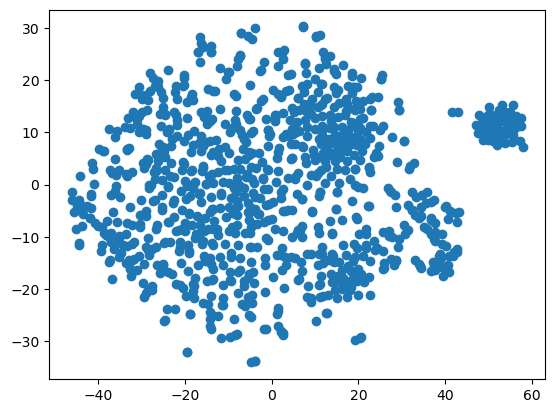

In [236]:
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])

In [237]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

X = phrase_embed_matrix
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [238]:
for i in range(indices.shape[0]):
  for j in range(indices.shape[1]):
    if j == 0:
      print(f'({phrases[indices[i,j]]})', end=', ')
      continue
    print(phrases[indices[i,j]], end=', ')
  print()
  print()

(college dorm decor), antique decor, daily table decoration, the decoration style, a sponge interior, elegant table decoration, the gate layout, chic design, dormitory, 24 projector patterns, 

(a virtual casino), the pool deck, your dollhouse, a sponge interior, a desktop lamp, a passport wallet, the gate layout, a triple locking system, " the carpet city, this stylish windmill, 

(empty glass bottle), one ink bottle, small bottle, tempered glass, punpun crystal whiskey glasses, a removable dry box, dial glass material, a table cloth, the grinding cup, toy phone case, 

(dji mavic air), kurta length, ezra pound, a-line kurti, portsmini hdmi, hologrpahic wristband, kurta straight, denon avr-s500bt, soft microsuede, these feeding kurtas, 

(multiple shockproof materials ]), safe and durable ], scratches and shock-proof, dial glass material, . skid-resistant backing, lightweight and waterproof material, a protective tube, a triple locking system, superior silicone material, thermal insul

In [242]:
from sklearn.cluster import KMeans

In [243]:
X = phrase_embed_matrix

# Perform K-means clustering
kmeans = KMeans(n_clusters=100)
kmeans.fit(X)

# Retrieve the cluster labels
labels = kmeans.labels_

# Create a dictionary to store clusters
clusters = {}
for i, label in enumerate(labels):
  if label not in clusters:
      clusters[label] = []
  clusters[label].append(phrases[i])

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [244]:
# Print the clusters
for label, phrases in clusters.items():
    print(f"Cluster {label}:")
    for phrase in phrases:
        print(phrase)
    print()

Cluster 22:
college dorm decor
traditional 5-pocket styling
seamless style
your personalized costumes
natural style
cool wearing experience
fancy designer look
free style
manicure tools
various styles
stylish contemporary look
antique decor
elegant table decoration
color and design
your new artwork
the decoration style
24 projector patterns
wall décor
decorative home accents
vivid farm style ]
updated style
daily table decoration
bedroom and study
modern , geometric style

Cluster 34:
a virtual casino
data transfer speed
the health breeze mode
better temperature regulation
sustainable hydrofree dwr treatment
our unique breeze-pass technology
comparable standard treble
a convenient name tag slot
shock cords and locks
odor protection technology
this seven chakra wand
a separate device
incoming natural light
a triple locking system
unconditional free returns
radio frequency interference
3000 rpm stall converter
. professional features8 gb inbuilt memory
anti-sliding design
a complex heat 